In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from itertools import chain

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn

import warnings
import plotly.offline as py

py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')

In [3]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)

    return rmse, mae, r2

In [4]:
dataset = pd.read_csv('Breast Cancer Data.csv')
X = dataset.iloc[:, 2:32].values
y = dataset.iloc[:, 1].values

# Encoding categorical data
labelencoder_X_1 = LabelEncoder()
y = labelencoder_X_1.fit_transform(y)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [5]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier()
}

for model_name, model in models.items():
    with mlflow.start_run():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        (rmse, mae, r2) = eval_metrics(y_test, y_pred)

        # Log model and metrics with MLflow
        mlflow.log_param('model', model_name)
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        # Log the model itself
        mlflow.sklearn.log_model(model, model_name, input_example=X_train[:5])

        print(f'{model_name} - Accuracy: {accuracy:.4f}')

Decision Tree - Accuracy: 0.9298
Logistic Regression - Accuracy: 0.9825
Support Vector Machine - Accuracy: 1.0000
Random Forest - Accuracy: 0.9649
KNN - Accuracy: 0.9912


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
data = dataset.copy()

In [8]:
# Drop useless variables
data = data.drop(['Unnamed: 32', 'id'], axis=1)
# Reassign target
data.diagnosis.replace(to_replace=dict(M=1, B=0), inplace=True)

In [9]:
M = data[(data['diagnosis'] != 0)]
B = data[(data['diagnosis'] == 0)]

In [10]:
trace = go.Bar(x=(len(M), len(B)), y=['malignant', 'benign'], orientation='h', opacity=0.8, marker=dict(
    color=['gold', 'lightskyblue'],
    line=dict(color='#000000', width=1.5)))

layout = dict(title='Count of diagnosis variable')

fig = dict(data=[trace], layout=layout)
py.iplot(fig)

trace = go.Pie(labels=['benign', 'malignant'], values=data['diagnosis'].value_counts(),
               textfont=dict(size=15), opacity=0.8,
               marker=dict(colors=['lightskyblue', 'gold'],
                           line=dict(color='#000000', width=1.5)))

layout = dict(title='Distribution of diagnosis variable')

fig = dict(data=[trace], layout=layout)
py.iplot(fig)

In [11]:
def plot_distribution(data_select, size_bin):
    tmp1 = M[data_select]
    tmp2 = B[data_select]
    hist_data = [tmp1, tmp2]

    group_labels = ['malignant', 'benign']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors, show_hist=True, bin_size=size_bin,
                             curve_type='kde')

    fig['layout'].update(title=data_select)

    py.iplot(fig, filename='Density plot')

In [12]:
plot_distribution('radius_mean', .5)
plot_distribution('texture_mean', .5)
plot_distribution('perimeter_mean', 5)
plot_distribution('area_mean', 10)

In [13]:
plot_distribution('radius_se', .1)
plot_distribution('texture_se', .1)
plot_distribution('perimeter_se', .5)
plot_distribution('area_se', 5)

In [14]:
plot_distribution('radius_worst', .5)
plot_distribution('texture_worst', .5)
plot_distribution('perimeter_worst', 5)
plot_distribution('area_worst', 10)

In [15]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array = np.array(correlation)

#Plotting
trace = go.Heatmap(z=corr_array,
                   x=matrix_cols,
                   y=matrix_cols,
                   xgap=2,
                   ygap=2,
                   colorscale='Viridis',
                   colorbar=dict(),
                   )
layout = go.Layout(dict(title='Correlation Matrix for variables',
                        autosize=False,
                        height=720,
                        width=800,
                        margin=dict(r=0, l=210,
                                    t=25, b=210,
                                    ),
                        yaxis=dict(tickfont=dict(size=9)),
                        xaxis=dict(tickfont=dict(size=9)),
                        )
                   )
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [16]:
def plot_feat1_feat2(feat1, feat2):
    trace0 = go.Scatter(
        x=M[feat1],
        y=M[feat2],
        name='malignant',
        mode='markers',
        marker=dict(color='#FFD700',
                    line=dict(
                        width=1)))

    trace1 = go.Scatter(
        x=B[feat1],
        y=B[feat2],
        name='benign',
        mode='markers',
        marker=dict(color='#7EC0EE',
                    line=dict(
                        width=1)))

    layout = dict(title=feat1 + " " + "vs" + " " + feat2,
                  yaxis=dict(title=feat2, zeroline=False),
                  xaxis=dict(title=feat1, zeroline=False)
                  )

    plots = [trace0, trace1]

    fig = dict(data=plots, layout=layout)
    py.iplot(fig)

In [17]:
plot_feat1_feat2('perimeter_mean', 'radius_worst')
plot_feat1_feat2('area_mean', 'radius_worst')
plot_feat1_feat2('texture_mean', 'texture_worst')
plot_feat1_feat2('area_worst', 'radius_worst')

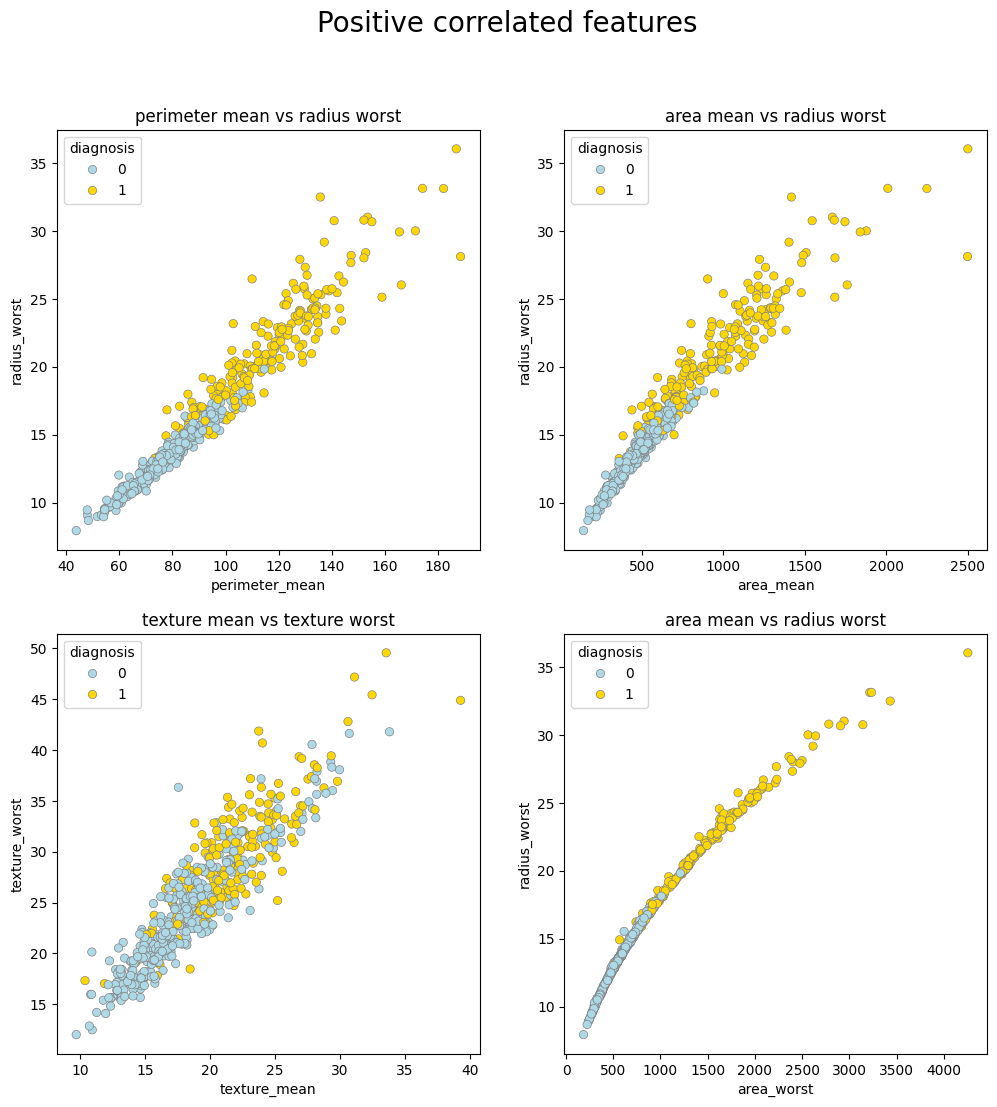

In [18]:
palette = {0: 'lightblue', 1: 'gold'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12, 12))

plt.subplot(221)
ax1 = sns.scatterplot(x=data['perimeter_mean'], y=data['radius_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('perimeter mean vs radius worst')
plt.subplot(222)
ax2 = sns.scatterplot(x=data['area_mean'], y=data['radius_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')
plt.subplot(223)
ax3 = sns.scatterplot(x=data['texture_mean'], y=data['texture_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('texture mean vs texture worst')
plt.subplot(224)
ax4 = sns.scatterplot(x=data['area_worst'], y=data['radius_worst'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')

fig.suptitle('Positive correlated features', fontsize=20)
plt.savefig('1')
plt.show()

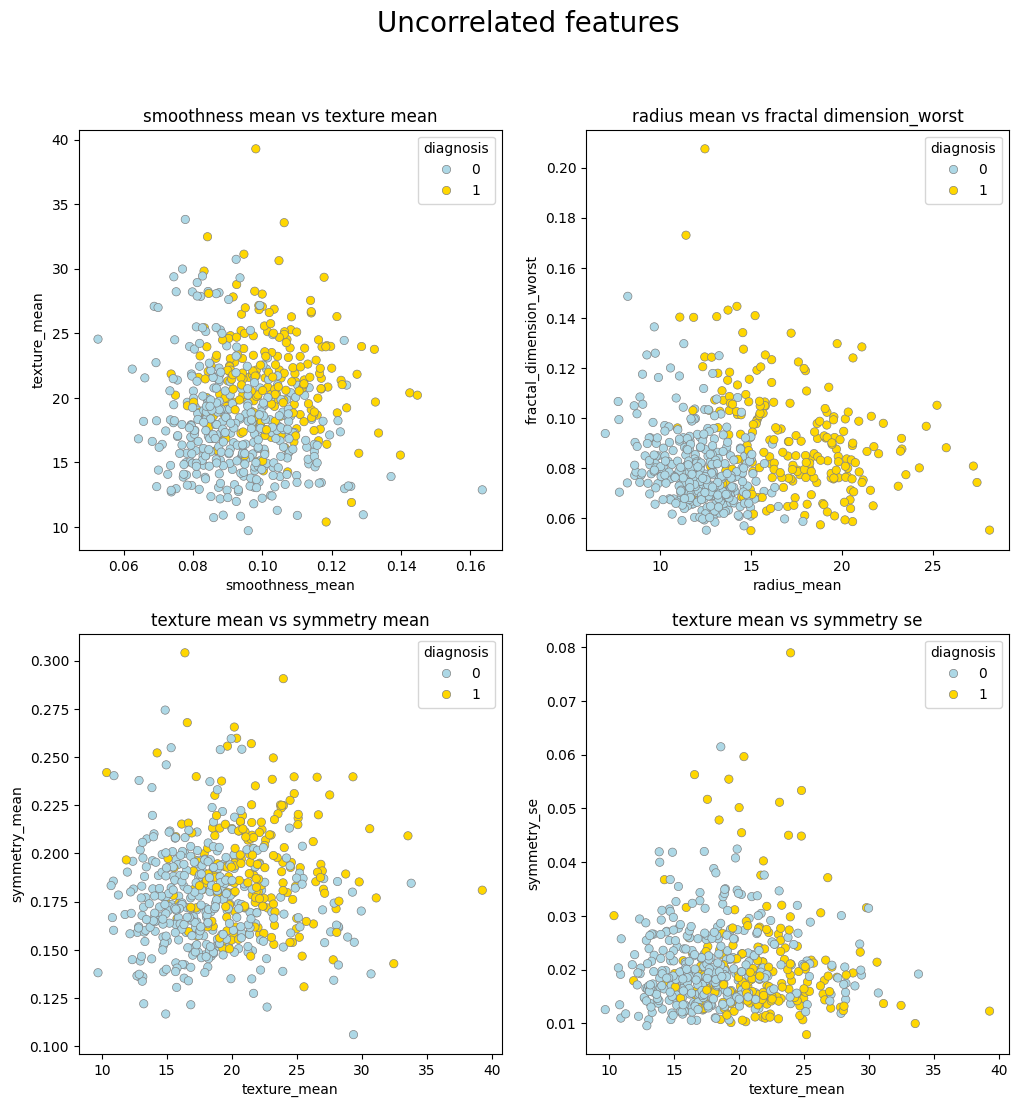

In [19]:
fig = plt.figure(figsize=(12, 12))

plt.subplot(221)
ax1 = sns.scatterplot(x=data['smoothness_mean'], y=data['texture_mean'], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
plt.title('smoothness mean vs texture mean')
plt.subplot(222)
ax2 = sns.scatterplot(x=data['radius_mean'], y=data['fractal_dimension_worst'], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension_worst')
plt.subplot(223)
ax3 = sns.scatterplot(x=data['texture_mean'], y=data['symmetry_mean'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry mean')
plt.subplot(224)
ax4 = sns.scatterplot(x=data['texture_mean'], y=data['symmetry_se'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry se')

fig.suptitle('Uncorrelated features', fontsize=20)
plt.savefig('2')
plt.show()

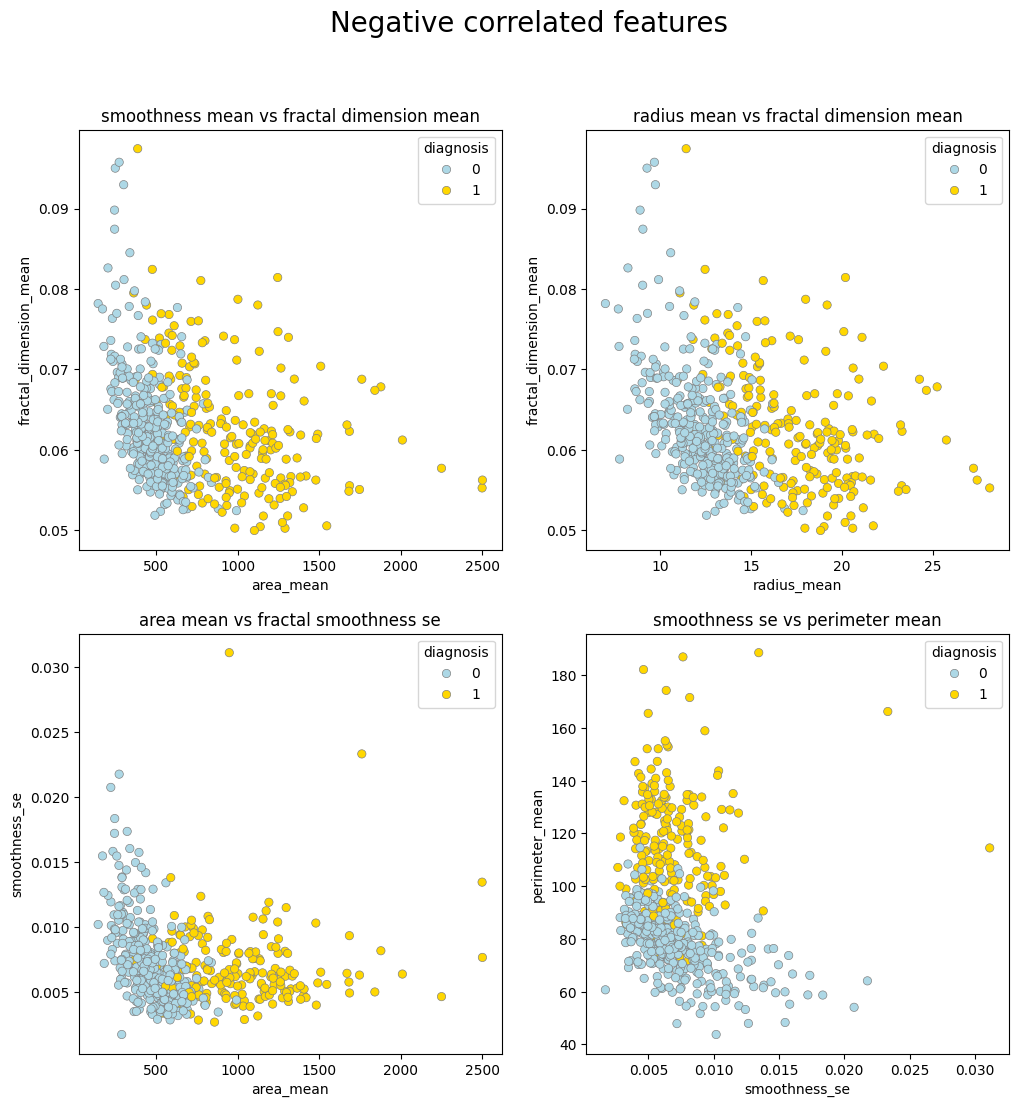

In [20]:
fig = plt.figure(figsize=(12, 12))

plt.subplot(221)
ax1 = sns.scatterplot(x=data['area_mean'], y=data['fractal_dimension_mean'], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
plt.title('smoothness mean vs fractal dimension mean')
plt.subplot(222)
ax2 = sns.scatterplot(x=data['radius_mean'], y=data['fractal_dimension_mean'], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension mean')
plt.subplot(223)
ax2 = sns.scatterplot(x=data['area_mean'], y=data['smoothness_se'], hue="diagnosis",
                      data=data, palette=palette, edgecolor=edgecolor)
plt.title('area mean vs fractal smoothness se')
plt.subplot(224)
ax2 = sns.scatterplot(x=data['smoothness_se'], y=data['perimeter_mean'], hue="diagnosis", data=data, palette=palette, edgecolor=edgecolor)
plt.title('smoothness se vs perimeter mean')

fig.suptitle('Negative correlated features', fontsize=20)
plt.savefig('3')
plt.show()

In [21]:
from sklearn.decomposition import PCA

target_pca = data['diagnosis']
data_pca = data.drop('diagnosis', axis=1)

target_pca = pd.DataFrame(target_pca)

#To make a PCA, normalize data is essential
X_pca = data_pca.values
X_std = StandardScaler().fit_transform(X_pca)

pca = PCA(svd_solver='full')
pca_std = pca.fit(X_std, target_pca).transform(X_std)

pca_std = pd.DataFrame(pca_std)
pca_std = pca_std.merge(target_pca, left_index=True, right_index=True, how='left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1: 'malignant', 0: 'benign'})

In [22]:
var_pca = pd.DataFrame(pca.explained_variance_ratio_)
var_pca = var_pca.T

#----------SUM AND DROP COMP [7:30]
col_list = list(v for v in chain(pca_std.columns[6:30]))
var_pca['OTHERS_COMP'] = var_pca[col_list].sum(axis=1)
var_pca.drop(var_pca[col_list], axis=1, inplace=True)
var_pca = var_pca.T

In [23]:
labels = ['COMP1', 'COMP2', 'COMP3', 'COMP4', 'COMP5', 'COMP6', 'COMP7 - 30']
colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightgrey', 'orange', 'white']

trace = go.Pie(labels=labels, values=var_pca[0].values, opacity=0.8,
               textfont=dict(size=15),
               marker=dict(colors=colors,
                           line=dict(color='#000000', width=1.5)))

layout = dict(title='PCA : components and explained variance (6 comp = 88.8%)')

fig = dict(data=[trace], layout=layout)
py.iplot(fig)

In [24]:
pca = PCA(n_components=2)

pca_std = pca.fit(X_std, target_pca).transform(X_std)
pca_std = pd.DataFrame(pca_std, columns=['COMP1', 'COMP2'])
pca_std = pca_std.merge(target_pca, left_index=True, right_index=True, how='left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1: 'malignant', 0: 'benign'})

In [25]:
def pca_scatter(target, color):
    tracer = go.Scatter(x=pca_std[pca_std['diagnosis'] == target]['COMP1'],
                        y=pca_std[pca_std['diagnosis'] == target]['COMP2'],
                        name=target, mode='markers',
                        marker=dict(color=color, line=dict(width=1))
                        )
    return tracer


layout = go.Layout(dict(title='PCA Scatter plot (2 comp = 63.3%)',
                        xaxis=dict(gridcolor='rgb(255, 255, 255)',
                                   title='COMP1 = 44.3%',
                                   zerolinewidth=1, ticklen=5, gridwidth=2),
                        yaxis=dict(gridcolor='rgb(255, 255, 255)',
                                   title='COMP2 = 19.0%',
                                   zerolinewidth=1, ticklen=5, gridwidth=2),
                        height=800
                        ))
trace1 = pca_scatter('malignant', '#FFD700')
trace2 = pca_scatter('benign', '#7EC0EE')
plots = [trace2, trace1]
fig = go.Figure(data=plots, layout=layout)
py.iplot(fig)

In [26]:
pca = PCA(n_components=3)
pca_std = pca.fit(X_std, target_pca).transform(X_std)

pca_std = pd.DataFrame(pca_std, columns=['COMP1', 'COMP2', 'COMP3'])
pca_std = pca_std.merge(target_pca, left_index=True, right_index=True, how='left')
pca_std['diagnosis'] = pca_std['diagnosis'].replace({1: 'malignant', 0: 'benign'})

In [27]:
M_pca = pca_std[(pca_std['diagnosis'] == 'malignant')]
B_pca = pca_std[(pca_std['diagnosis'] == 'benign')]

In [28]:
trace1 = go.Scatter3d(x=M_pca['COMP1'],
                      y=M_pca['COMP3'],
                      z=M_pca['COMP2'],
                      mode="markers",
                      name="malignant",
                      marker=dict(size=4, color='#FFD700', line=dict(width=1))
                      )
trace2 = go.Scatter3d(x=B_pca['COMP1'],
                      y=B_pca['COMP3'],
                      z=B_pca['COMP2'],
                      name='benign',
                      mode='markers',
                      marker=dict(size=4, color='#7EC0EE', line=dict(width=1))
                      )

layout = go.Layout(dict(title='PCA Scatter plot (3 comp = 72.7%)',
                        scene=dict(camera=dict(up=dict(x=0, y=0, z=0),
                                               center=dict(x=0, y=0, z=0),
                                               eye=dict(x=1.25, y=1.25, z=1.25)),
                                   xaxis=dict(title='COMP1',
                                              gridcolor='rgb(255, 255, 255)',
                                              zerolinecolor='rgb(255, 255, 255)',
                                              showbackground=True,
                                              backgroundcolor='rgb(230, 230,230)'),
                                   yaxis=dict(title='COMP3',
                                              gridcolor='rgb(255, 255, 255)',
                                              zerolinecolor='rgb(255, 255, 255)',
                                              showbackground=True,
                                              backgroundcolor='rgb(230, 230,230)'
                                              ),
                                   zaxis=dict(title='COMP2',
                                              gridcolor='rgb(255, 255, 255)',
                                              zerolinecolor='rgb(255, 255, 255)',
                                              showbackground=True,
                                              backgroundcolor='rgb(230, 230,230)'
                                              )), height=700))

plots = [trace1, trace2]
fig = go.Figure(data=plots, layout=layout)
py.iplot(fig)